## Final Project: House Prices Prediction
https://www.kaggle.com/c/house-prices-advanced-regression-techniques  

### Team MLAIRE: Chi Iong Ansjory, Prabhat Tripathi, Soodong Kim, Tina Agarwal

## Problem

The goal of this project is to predict sale price of residential homes in Ames, Iowa based on the given training and test data sets. There are 79 explanatory variables describing different aspects of residential homes with 1460 observations in both training and test data sets (this is different than previous class projects where train data is usually larger than test data set). 

The output variable (SalePrice) is quantitative (continuous) whereas the explanatory (LHS) variables are a combination of quantitative (continuous) and categorical variables. 

Considering the size and nature of the data set, and informed by our domain understanding, we beleive that *feature engineering* -- crafting data features optimized for machine learning -- is key for better modeling for this problem. Specifically, we plan to perform following:

- Univariate analysis of output and explanatory variables: weed out spurious or wrong values. Understand patterns and outliers for each variable. Allow for missing values (NaN) imputations.
- Transform categorical variables into numeric (using dummy variables?)
- Check if log transformation of output and explanatory variables helps better model performance
- Identify and remove unhelpful explanatory variables (using correlation matrix or using techniques such as LASSO)
- Identify and remove multicollinearity, if present
- Advance feature engineering techniques such as PCA?

We also have to watch out for overfitting considering there are a large number of input variables (compared to the training data size).

We plan to begin with (multiple) LinearRegression model (for speed) and if the accuracy is not satisfactory, we would try other models such as random forest and gradient-boosting tree. If needed, we may have to ensemble all these models for better overall accuracy. We will split test data into two random sets and use one as "dev" data during model buidling process.

### Import Libraries

In [46]:
# Each plot will not open a new window. 
# required libraries
## pandas
## seaborn
## XGBoost -- allows for correlated features
%matplotlib inline

# Import relevant libraries.

# General libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

from scipy.stats import norm
from scipy import stats

# Libraries for files
import os

# Python fundamental libraries
import collections

# Disable warnings for more clear output
import warnings 
warnings.filterwarnings('ignore')

## Data Loading

### Import Data

In [1]:
# Load Data
from sklearn.cross_validation import train_test_split

# Please keep this relative path access to data.
dir_name = os.getcwd()
train_filename = os.path.join(dir_name, 'data/train.csv')
test_filename = os.path.join(dir_name, 'data/test.csv')

# Reading the data
train = pd.read_csv(train_filename)
test  = pd.read_csv(test_filename)
train_ = train.copy()
test_ = test.copy()

print("original shapes of train and test datasets")
train.shape, test.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


NameError: name 'os' is not defined

## Explanatory Data Analysis

### Features Summary

In this section, we summarize the train dataset features:  
* categorize 80 features into numerical, categorical. Among numerical features, distinguish "discrete" values features
* print a summary of numerical features with info such as: mean, min, max, number of NaNs, isDiscrete
* print a summary of categorical features with info such as: number of NaNs, number of disntict values 

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Descriptions of variables are based on https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. Variable types are either categorical, or discrete/non-discrete numeric. There are 4 different segments: Sale (sales transaction of house), Location (where the house located), Building (physical characteristics), Space (space properties of house). There are 3 levels of expectations: High, Medium, and Low of how the variables are related to the sale price.

| Variable | Description | Type | Segment | Expectation | Comments |
| --- | --- | --- | --- |
| SalePrice | Property's sale price in dollars | Numeric | Building | Target Variable | |
| MSSubClass | Building class | Categorical | Building | Low | |
| MSZoning | General zoning classification | Categorical | Building | Low | |
| LotFrontage | Linear feet of street connected to property | Numeric | Space | Medium | Needs missing data handling |
| LotArea | Lot size in square feet | Numeric | Space | High | |
| Street | Type of road access | Categorical | Location | Low | |
| Alley | Type of alley access | Categorical | Location | Low | Needs NA to be renamed |
| LotShape | General shape of property | Categorical | Location | Low | |
| LandContour | Flatness of the property | Categorical | Location | Low | |
| Utilities | Type of utilities available | Categorical | Location | Low | Can be removed since all are AllPub |
| LotConfig | Lot configuration | Categorical | Location | Medium | |
| LandSlope | Slope of property | Categorical | Location | Low | |
| Neighborhood | Physical locations within Ames city limits | Categorical | Location | High | |
| Condition1 | Proximity to main road or railroad | Categorical | Location | Medium | |
| Condition2 | Proximity to main road or railroad (if a second is present) | Categorical | Location | Low | |
| BldgType | Type of dwelling | Categorical | Building | Low | |
| HouseStyle | Style of dwelling | Categorical | Building | Low | |
| OverallQual | Overall material and finish quality | Categorical | Building | High | |
| OverallCond | Overall condition rating | Categorical | Building | Medium | |
| YearBuilt | Original construction date | Categorical | Building | High | |
| YearRemodAdd | Remodel date | Categorical | Building | Medium | |
| RoofStyle | Type of roof | Categorical | Building | Medium | |
| RoofMatl | Roof material | Categorical | Building | Low | |
| Exterior1st | Exterior covering on house | Categorical | Building | Medium | |
| Exterior2nd | Exterior covering on house (if more than one material) | Categorical | Building | Low | |
| MasVnrType | Masonry veneer type | Categorical | Building | Low | |
| MasVnrArea | Masonry veneer area in square feet | Numeric | Space | Low | |
| ExterQual | Exterior material quality | Categorical | Building | Low | |
| ExterCond | Present condition of the material on the exterior | Categorical | Building | Medium | |
| Foundation | Type of foundation | Categorical | Building | Low | |
| BsmtQual | Height of the basement | Categorical | Building | Low | |
| BsmtCond | General condition of the basement | Categorical | Building | Medium | |
| BsmtExposure | Walkout or garden level basement walls | Categorical | Building | Low | |
| BsmtFinType1 | Quality of basement finished area | Categorical | Building | Low | |
| BsmtFinSF1 | Type 1 finished square feet | Numeric | Space | Medium | |
| BsmtFinType2 | Quality of second finished area (if present) | Categorical | Building | Low | |
| BsmtFinSF2 | Type 2 finished square feet | Numeric | Space | Low | |
| BsmtUnfSF | Unfinished square feet of basement area | Numeric | Space | Medium | |
| TotalBsmtSF | Total square feet of basement area | Numeric | Space | High | |
| Heating | Type of heating | Categorical | Building | Low | |
| HeatingQC | Heating quality and condition | Categorical | Building | Low | |
| CentralAir | Central air conditioning | Categorical | Building | Medium | |
| Electrical | Electrical system | Categorical | Building | Low | |
| 1stFlrSF | First Floor square feet | Numeric | Space | Medium | |
| 2ndFlrSF | Second floor square feet | Numeric | Space | Medium | |
| LowQualFinSF | Low quality finished square feet (all floors) | Numeric | Space | Low | |
| GrLivArea | Above grade (ground) living area square feet | Numeric | Space | High | |
| BsmtFullBath | Basement full bathrooms | Numeric | Building | Low | Discrete |
| BsmtHalfBath | Basement half bathrooms | Numeric | Building | Low | Discrete |
| FullBath | Full bathrooms above grade | Numeric | Building | Medium | Discrete |
| HalfBath | Half baths above grade | Numeric | Building | Low | Discrete |
| BedroomAbvGr | Number of bedrooms above basement level | Numeric | Building | High | Discrete |
| Kitchen | Number of kitchens | Numeric | Building | Low | Discrete|
| KitchenQual | Kitchen quality | Categorical | Building | Medium | |
| TotRmsAbvGrd | Total rooms above grade (does not include bathrooms) | Numeric | Building | Medium | Discrete |
| Functional | Home functionality rating | Categorical | Building | Low | |
| Fireplaces | Number of fireplaces | Numeric | Building | Medium | Discrete |
| FireplaceQu | Fireplace quality | Categorical | Building | Low | |
| GarageType | Garage location | Categorical | Building | Low | |
| GarageYrBlt | Year garage was built | Categorical | Building | Low | |
| GarageFinish | Interior finish of the garage | Categorical | Building | Low | |
| GarageCars | Size of garage in car capacity | Numeric | Building | High | Discrete |
| GarageArea | Size of garage in square feet | Numeric | Space | Medium | |
| GarageQual | Garage quality | Categorical | Building | Low | |
| GarageCond | Garage condition | Categorical | Building | Low | |
| PavedDrive | Paved driveway | Categorical | Building | Medium | |
| WoodDeckSF | Wood deck area in square feet | Numeric | Space | Low | |
| OpenPorchSF | Open porch area in square feet | Numeric | Space | Low | |
| EnclosedPorch | Enclosed porch area in square feet | Numeric | Space | Low | |
| 3SsnPorch | Three season porch area in square feet | Numeric | Space | Low | |
| ScreenPorch | Screen porch area in square feet | Numeric | Space | Low | |
| PoolArea | Pool area in square feet | Numeric | Space | Medium | |
| PoolQC | Pool quality | Categorical | Building | Low | |
| Fence | Fence quality | Categorical | Building | Low | |
| MiscFeature | Miscellaneous feature not covered in other categories | Categorical | Building | Low | |
| MiscVal | $Value of miscellaneous feature | Numeric | Building | Low | |
| MoSold | Month Sold | Categorical | Sale | Medium | |
| YrSold | Year Sold | Categorical | Sale | High | |
| SaleType | Type of sale | Categorical | Sale | Medium | |
| SaleCondition | Condition of sale | Categorical | Sale | High | |

### Uni-variate analysis:

Identify 15-20 interesting features and perform their data analysis
* SalePrice
* numeric1 feature
* numeric2 feature
* discrete1 feature
*...
* categorical1 feature
...

We can use plots such as Histogram, boxplot to understand their distribution and general structure of these features
* note outliers
* note if some transformation of a feature would help
* practical and statistical significant?

Data analysis for explanatory variable *SalePrice*:

In [15]:
# Descriptive statistics
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

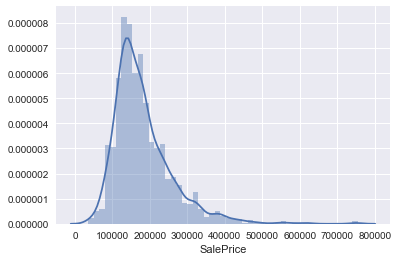

In [65]:
# Histogram
sns.distplot(train['SalePrice'])

In [18]:
# Skewness and Kurtosis
print("Skewness: ", train['SalePrice'].skew())
print("Kurtosis: ", train['SalePrice'].kurt())

Skewness:  1.8828757597682129
Kurtosis:  6.536281860064529


*MSSubClass* 20 (1-STORY 1946 & NEWER ALL STYLES) and 60 (2-STORY 1946 & NEWER) have major contribution:

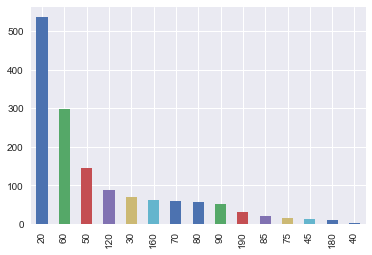

In [82]:
# Histogram
train['MSSubClass'].value_counts().plot(kind='bar')

*MSZoning* RL (Residential Low Density) has the major contribution:

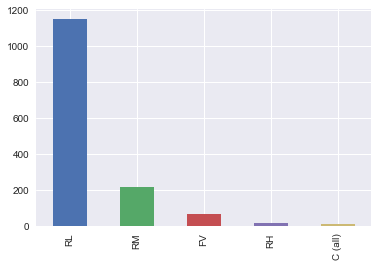

In [83]:
# Histogram
train['MSZoning'].value_counts().plot(kind='bar')

*LotFrontage* needs to have missing data removed.

Data Analysis for numeric feature *LotArea*, which is continuous and related to segment Space:

In [53]:
# Descriptive statistics
train['LotArea'].describe()

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

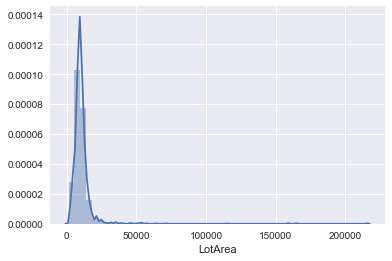

In [54]:
# Histogram
sns.distplot(train['LotArea'])

In [55]:
# Skewness and Kurtosis
print("Skewness: ", train['LotArea'].skew())
print("Kurtosis: ", train['LotArea'].kurt())

Skewness:  12.207687851233496
Kurtosis:  203.24327101886033


*Street* Pave has major contribution:

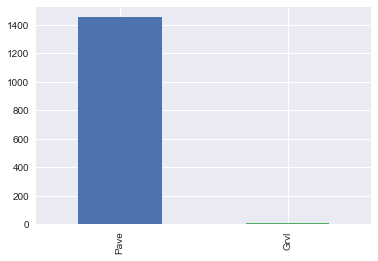

In [85]:
# Histogram
train['Street'].value_counts().plot(kind='bar')

*Alley* needs to have NA (No Alley Access) renamed.

LotShape Reg (Regular) has major contribution:

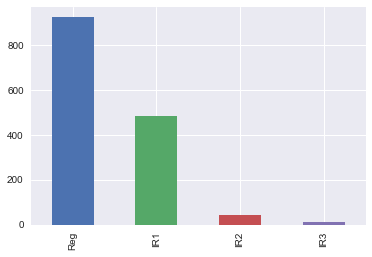

In [87]:
# Histogram
train['LotShape'].value_counts().plot(kind='bar')

*LandContour* Lvl (Near Flat/Level) has major contribution:

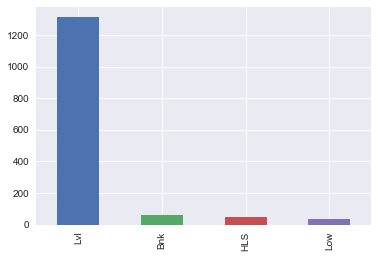

In [89]:
# Histogram
train['LandContour'].value_counts().plot(kind='bar')

*LotConfig* Inside (Inside Lot) has major contribution:

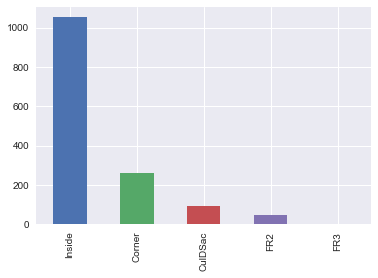

In [91]:
# Histogram
train['LotConfig'].value_counts().plot(kind='bar')

*LandSlope* Gtl (Gentle Slope) has major contribution:

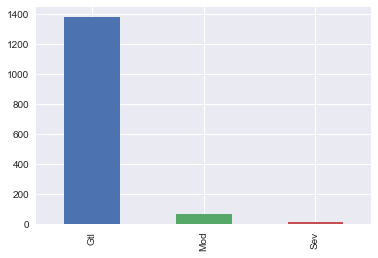

In [92]:
# Histogram
train['LandSlope'].value_counts().plot(kind='bar')

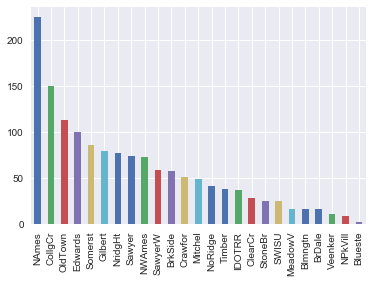

In [94]:
# Histogram
train['Neighborhood'].value_counts().plot(kind='bar')

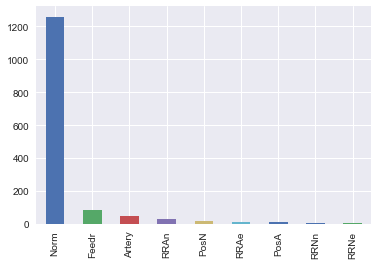

In [97]:
# Histogram
train['Condition1'].value_counts().plot(kind='bar')

*BldgType* 1Fam (Single Family Detached) has major contribution:

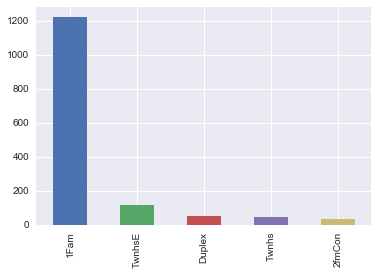

In [99]:
# Histogram
train['BldgType'].value_counts().plot(kind='bar')

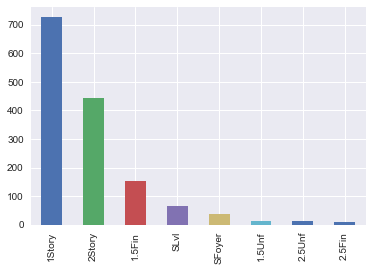

In [100]:
# Histogram
train['HouseStyle'].value_counts().plot(kind='bar')

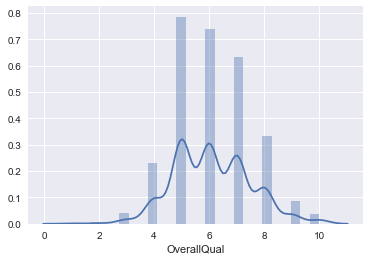

In [102]:
# Histogram
sns.distplot(train['OverallQual'])

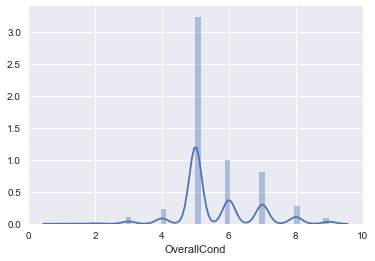

In [103]:
# Histogram
sns.distplot(train['OverallCond'])

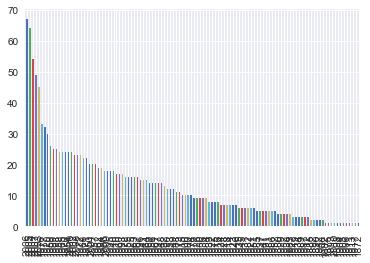

In [104]:
# Histogram
train['YearBuilt'].value_counts().plot(kind='bar')

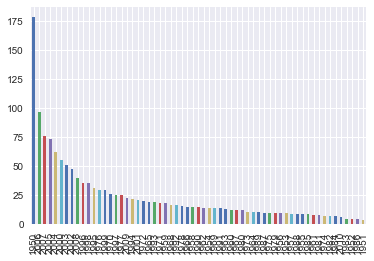

In [105]:
# Histogram
train['YearRemodAdd'].value_counts().plot(kind='bar')

Data Analysis for numeric feature *BedroomAbvGr*, which is discrete and related to segment Building:

In [61]:
# Descriptive statistics
train['BedroomAbvGr'].describe()

count    1460.000000
mean        2.866438
std         0.815778
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         8.000000
Name: BedroomAbvGr, dtype: float64

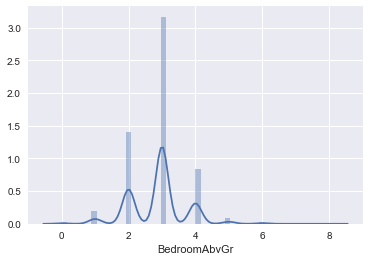

In [62]:
# Histogram
sns.distplot(train['BedroomAbvGr'])

Data Analysis for categorical feature *MoSold*, which is related to segment Sale:

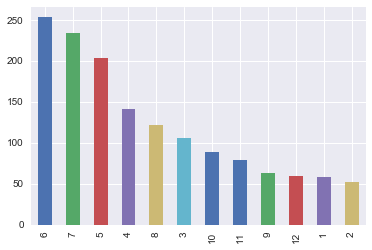

In [73]:
# Histogram
train['MoSold'].value_counts().plot(kind='bar')

Data Analysis for categorical feature *SaleCondition*, which is related to segment Sale:

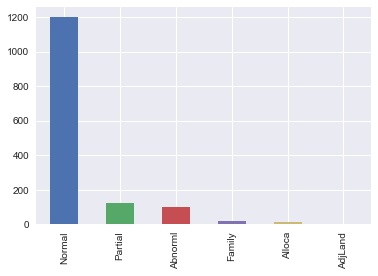

In [72]:
# Histogram
train['SaleCondition'].value_counts().plot(kind='bar')

For relationship with numeric features, picking 2 numeric features (TotalBsmtSF, GrLivArea) with expectation "high" from "building" segment:

In [23]:
# Descriptive statistics
var = 'TotalBsmtSF'
train[var].describe()

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

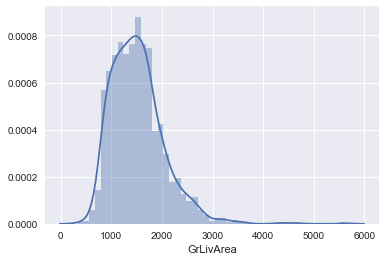

In [74]:
# Histogram
sns.distplot(train[var])

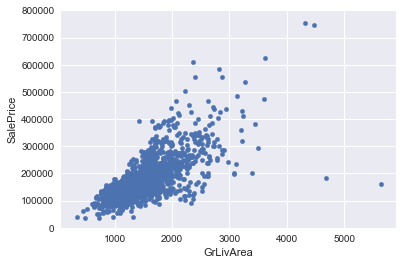

In [75]:
# Scatterplot of totalbsmtsf/saleprice
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [67]:
# Descriptive statistics
var = 'GrLivArea'
train[var].describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

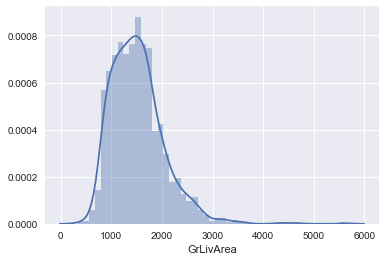

In [68]:
# Histogram
sns.distplot(train[var])

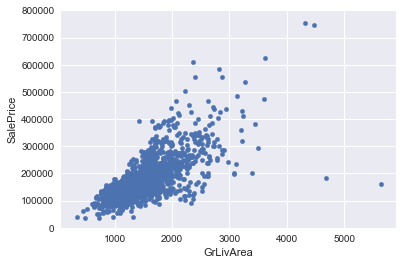

In [76]:
# Scatterplot of grlivarea/saleprice
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

For relationship with categorical features, picking categorical features (OverallQual, YearBuilt) with expectation "high" from "building" segment, and categorical feature (Neighborhood) with expectation "high" from "location" segment:

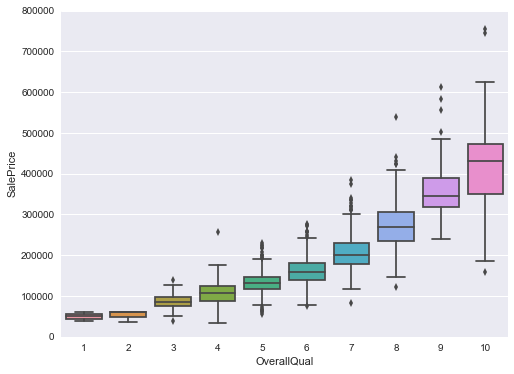

In [77]:
# Boxplot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

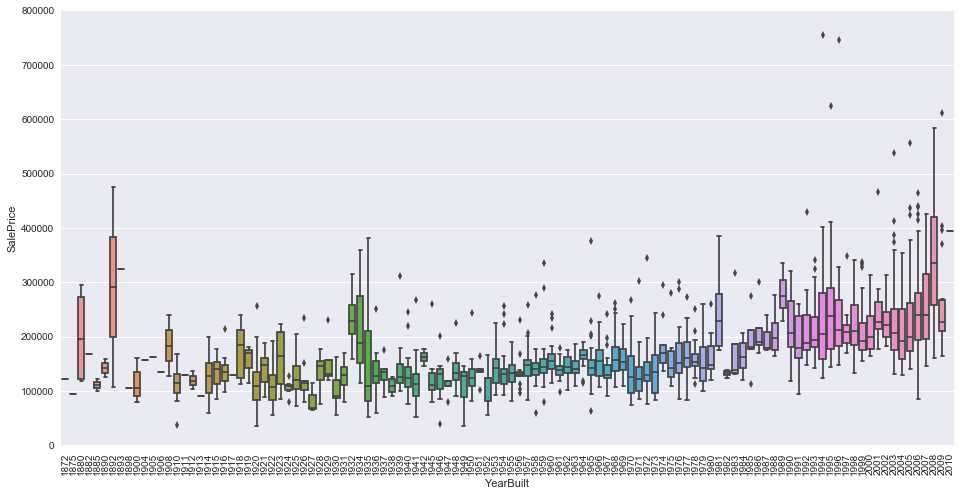

In [78]:
# Boxplot yearbuilt/saleprice
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90);

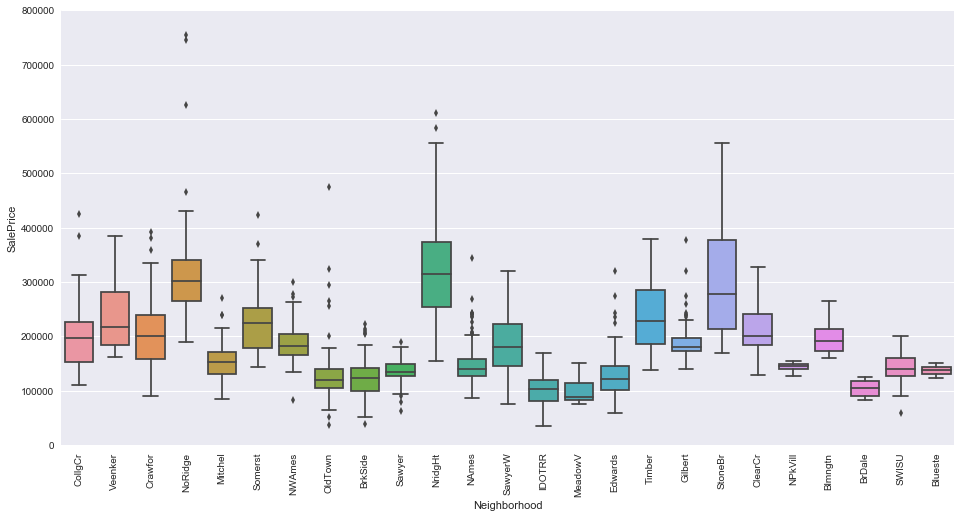

In [79]:
# Boxplot neighborhood/saleprice
var = 'Neighborhood'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90);

For relationship with discrete features, picking numeric discrete features (GarageCars) with expectation "high" from "building" segment:

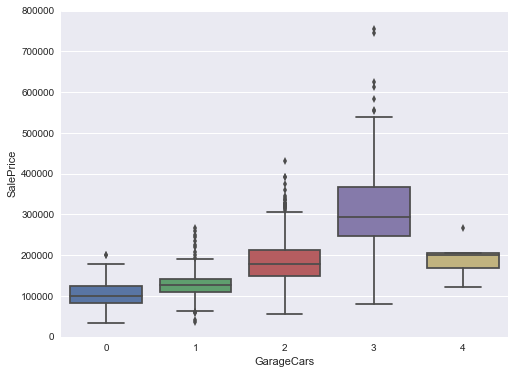

In [80]:
# Boxplot garagecars/saleprice
var = 'GarageCars'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

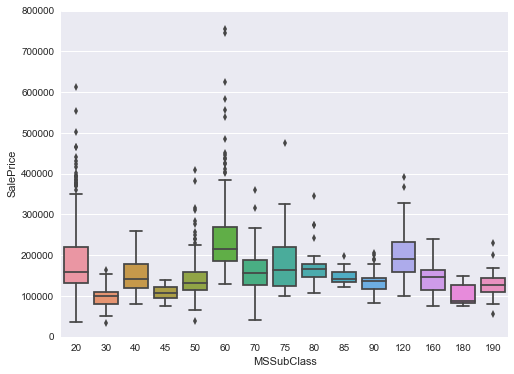

In [81]:
# Boxplot garagecars/saleprice
var = 'MSSubClass'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

### Bi-variate analysis

Find correlation between SalePrice and a set of important idenfied features (10-15) and plot their correlation matrix. Since Id is irrelevant column, it will be dropped.

In [2]:
# Correlation matrix showing evidence of multicollearity
# Remove Id column which is totally un
copied_train = train.copy()
copied_train = copied_train.drop(['Id'],axis=1,errors='raise')
corrmat = copied_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

NameError: name 'train' is not defined

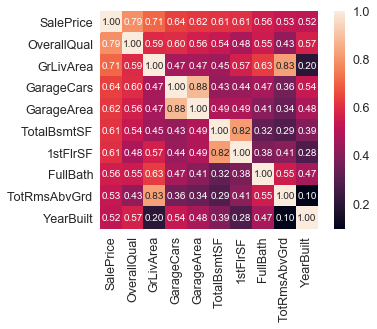

In [36]:
# Saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

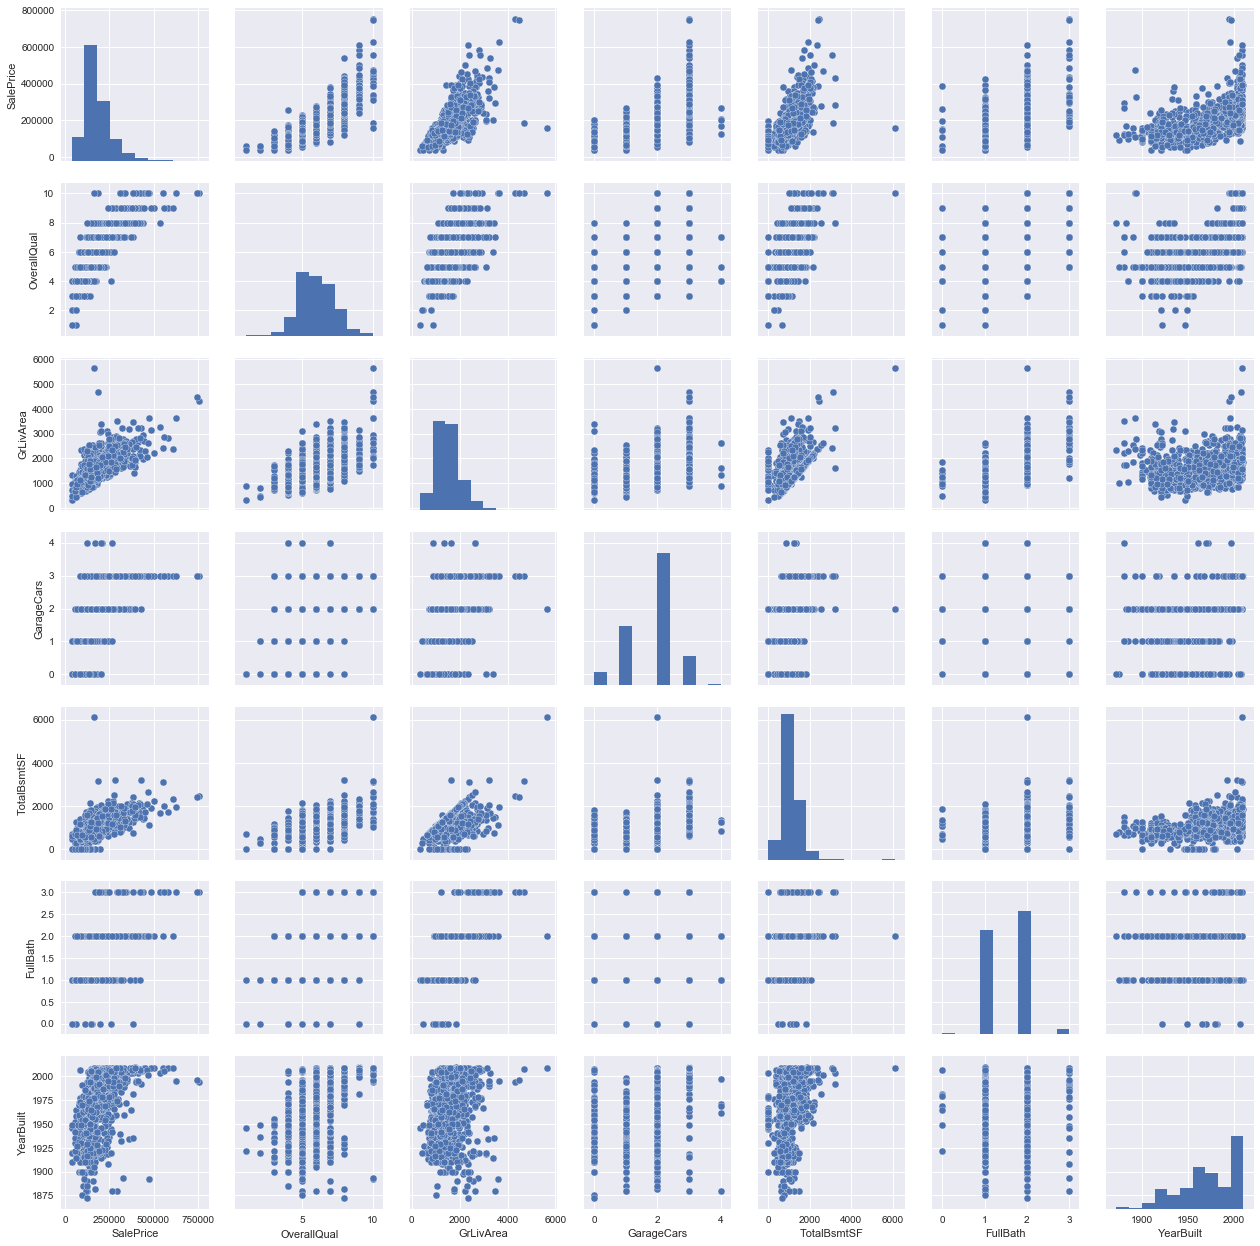

In [38]:
# Scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

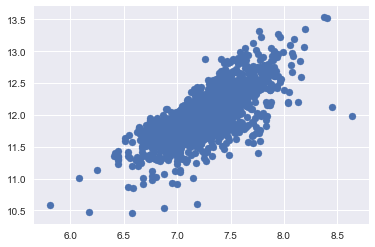

In [51]:
# Scatterplot after log transformation showing allevation of homoscedasticity problem
plt.scatter(np.log(train['GrLivArea']), np.log(train['SalePrice']));

### Missing Data Analysis

Find missing data in the dataset and propose a way to fix them
* remove some column (bad features)?
* remove some rows (bad rows)?
* impute values by some default or mean/mode/mediun of present values?

## Feature Engineering

* How to transform numeric features
* List all the features that needs Log transformation (including SalePrice output variable if needed)
* Perform log-transformation and add into the dataframe as new columns
* Normalize numeric features using SandardScaler?



* How to transform categorical features?
- using pandas getDummies?
- using sklearn ordinal encoding or one-hot encoding?
- some other methods?



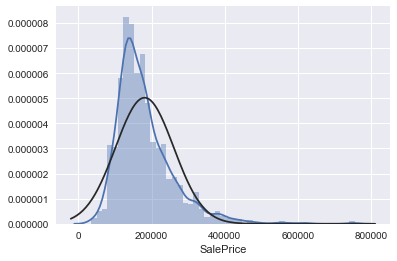

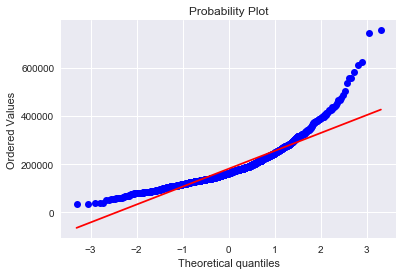

In [47]:
# Hstogram and normal probability plot
sns.distplot(train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

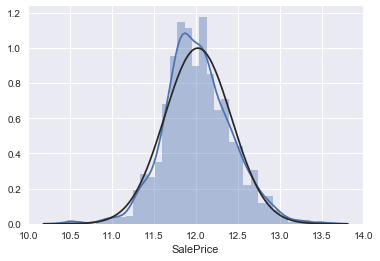

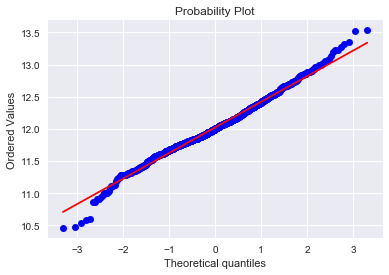

In [49]:
# Log transformed histogram and normal probability plot
sns.distplot(np.log(train['SalePrice']), fit=norm);
fig = plt.figure()
res = stats.probplot(np.log(train['SalePrice']), plot=plt)

At the end, all the above analysis should result into these final data frames

X_train: contains all relevant features and their values (transformed if relevant)  

Y_train: (transformed) SalePrice column  

X_test: contains tranformed dataframe from train data set (same tranformation as that was done for train)  


In [3]:
# Investigate about missing data
# Analyze top 15 columns having missing data

total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum() / train.isnull().count() * 100).sort_values(ascending=False)
missing_data = pd.concat(
    [total, percent], axis=1, keys=["Total Number of Missing Data", "Missing Data Percentage"])
missing_data.head(20)

,Total Number of Missing Data,Missing Data Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


There are 4 fields whose missing data portion is larger than 50%. Missing data will be cleaned up in the follow-up section.

## Data Clean Up

### Fill Missing Values

For string data columns, default value can be guessed from the documnation.
For non string data columns, zero or none can be assigned.

In [4]:
missing = train.isnull().sum().sort_values(ascending = False)
pd.concat([missing, missing / train.shape[0]], axis=1, keys=['Num', 'Ratio'])

,Num,Ratio
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [5]:
bad_features = ['Id','PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
                'GarageFinish', 'GarageType', 'GarageQual', 'GarageYrBlt', 'GarageCond', 
                'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']

train.drop(bad_features, axis=1, inplace=True)
test.drop(bad_features, axis=1, inplace=True)

In [6]:
print("shape of train after removing bad features: {}".format(train.shape))
print("shape of test after removing bad features: {}".format(test.shape))

shape of train after removing bad features: (1460, 64)
shape of test after removing bad features: (1459, 63)


In [7]:
numerical_features = train.select_dtypes(exclude = ['object']).columns
categorical_features = train.select_dtypes(include = ["object"]).columns

# find discrete features within numerical features
discrete_features = []
print("Discrete numerical features:")
for var in numerical_features:
    if len(train[var].unique())<20:
        print(var, ' values: ', train[var].unique())
        discrete_features.append(var)
        
print('**There are {} categorical variables; {} discrete variables out of {} total numeric vars**'.format(len(discrete_features), len(discrete_features), len(numerical_features)))

numerical_features, categorical_features

Discrete numerical features:
MSSubClass  values:  [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual  values:  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond  values:  [5 8 6 7 4 2 3 9 1]
BsmtFullBath  values:  [1 0 2 3]
BsmtHalfBath  values:  [0 1 2]
FullBath  values:  [2 1 3 0]
HalfBath  values:  [1 0 2]
BedroomAbvGr  values:  [3 4 1 2 0 5 6 8]
KitchenAbvGr  values:  [1 2 3 0]
TotRmsAbvGrd  values:  [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces  values:  [0 1 2 3]
GarageCars  values:  [2 3 1 0 4]
PoolArea  values:  [  0 512 648 576 555 480 519 738]
MoSold  values:  [ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold  values:  [2008 2007 2006 2009 2010]
**There are 15 categorical variables; 15 discrete variables out of 35 total numeric vars**


(Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
       dtype='object'),
 Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
        'Functional', 'PavedDrive', 'SaleType', 'SaleCondition

In [8]:
#dev =  train.sample(frac=1).head(100)
#train_data = train[101:][:]
#train_data.info()
#print("shape of train data: {}".format(train_data.shape))

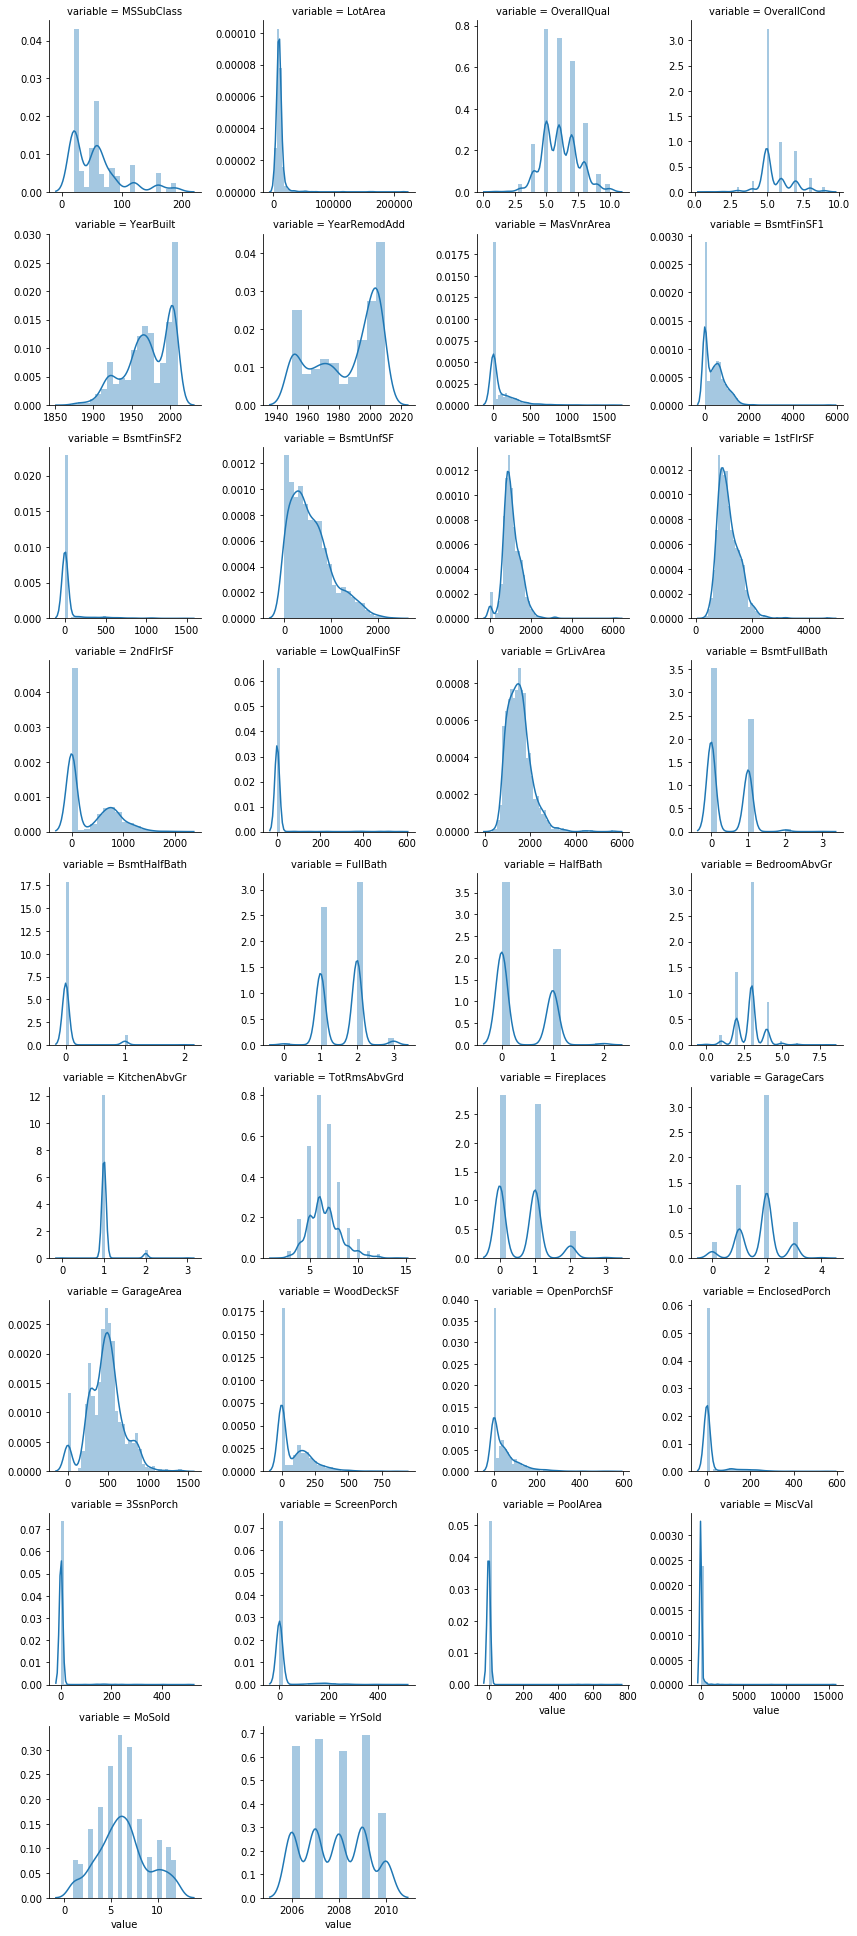

In [9]:
import seaborn as sns
num_melt = pd.melt(train, id_vars=['SalePrice'], 
                   value_vars = [f for f in numerical_features if f not in ['Id', 'SalePrice']])
g = sns.FacetGrid(data=num_melt, col="variable", col_wrap=4, sharex=False, sharey=False)
g.map(sns.distplot, "value")

Find and plan model tuning for these types of features
* near normal features
* bi modal features
* multi-modal features

In [10]:
log_features = ['LotArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea']

for f in log_features:
    train[f + '_Log'] = np.log1p(train[f])
    test[f + '_Log'] = np.log1p(test[f])

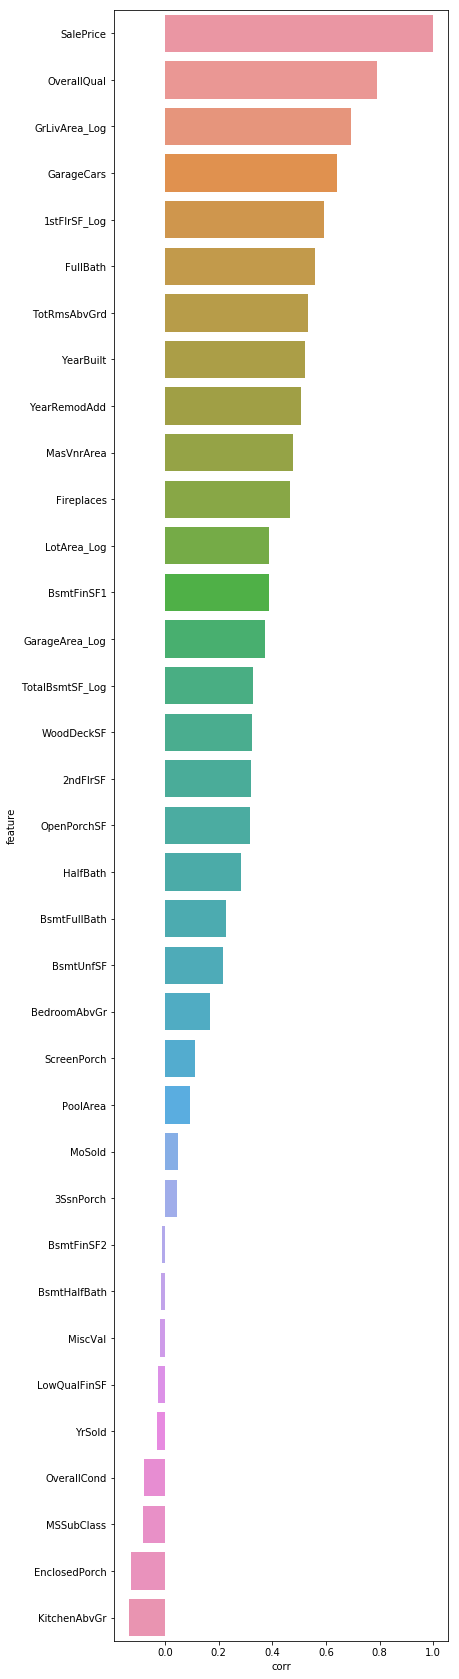

In [11]:
corr = train.drop(log_features, axis=1).corr()
corr = corr.SalePrice
from pandas import Series, DataFrame
m = DataFrame(pd.concat([DataFrame(corr.index, columns=['feature']), DataFrame(corr.values, columns=['corr'])], axis=1))
plt.figure(figsize=(6, 30))
sns.barplot(data=m.sort_values(by='corr', ascending=False), x='corr', y='feature')

In [12]:
train.drop(train[(train.LotShape == 'IR2') & (train.SalePrice > 300000)].index, inplace=True)
train.drop(train[(train.LandContour == 'Bnk') & (train.SalePrice > 300000)].index, inplace=True)
train.drop(train[(train.PavedDrive == 'P') & (train.SalePrice > 200000)].index, inplace=True)
train.drop(train[(train.MSZoning == 'RL') & (train.SalePrice > 500000)].index, inplace=True)
train.drop(train[(train.KitchenQual == 'TA') & (train.SalePrice > 300000)].index, inplace=True)
train.drop(train[(train.MSZoning == 'RM') & (train.SalePrice > 350000)].index, inplace=True)
train.drop(train[(train.LotConfig == 'Corner') & (train.SalePrice > 410000)].index, inplace=True)
train.drop(train[(train.Functional == 'Min2') & (train.SalePrice > 300000)].index, inplace=True)
train.drop(train[(train.HouseStyle == '1.5Fin') & (train.SalePrice > 400000)].index, inplace=True)
train.drop(train[(train.LandContour == 'Low') & (train.SalePrice > 350000)].index, inplace=True)

missing_idx = [977, 1278, 234, 973, 1243, 650, 936, 529, 1379]
train.loc[missing_idx, ['MasVnrType', 'MasVnrArea', 'Electrical']]

train.drop(missing_idx, inplace=True)


train.drop(train[train.LotArea > 100000].index, inplace=True)
train.drop(train[train.MasVnrArea > 1500].index, inplace=True)
train.drop(train[train.BsmtFinSF1 > 4000].index, inplace=True)
train.drop(train[train.BsmtFinSF2 > 1300].index, inplace=True)
train.drop(train[train.TotalBsmtSF > 4000].index, inplace=True)
train.drop(train[train['1stFlrSF'] > 4000].index, inplace=True)
train.drop(train[train.LowQualFinSF == 572].index, inplace=True)
train.drop(train[train.GrLivArea > 4000].index, inplace=True)
train.drop(train[train.OpenPorchSF == 523].index, inplace=True)
train.drop(train[train.MiscVal > 5000].index, inplace=True)




# assign default values for NaN
test.loc[test.MasVnrType.isnull(), 'MasVnrType'] = 'None'
test.loc[test.MasVnrArea.isnull(), 'MasVnrArea'] = 0.0
test.loc[test.MSZoning.isnull(), 'MSZoning'] = 'RL'
test.loc[test.BsmtFullBath.isnull(), 'BsmtFullBath'] = 0
test.loc[test.BsmtHalfBath.isnull(), 'BsmtHalfBath'] = 0
test.loc[test.Functional.isnull(), 'Functional'] = 'Typ'
test.loc[test.Utilities.isnull(), 'Utilities'] = 'AllPub'
test.loc[test.BsmtFinSF2.isnull(), 'BsmtFinSF2'] = 0
test.loc[test.SaleType.isnull(), 'SaleType'] = 'WD'
test.loc[test.TotalBsmtSF.isnull(), 'TotalBsmtSF'] = 0
test.loc[test.KitchenQual.isnull(), 'KitchenQual'] = 'TA'
test.loc[test.BsmtUnfSF.isnull(), 'BsmtUnfSF'] = 0
test.loc[test.Exterior1st.isnull(), 'Exterior1st'] = 'VinylSd'
test.loc[test.GarageArea_Log.isnull(), 'GarageArea_Log'] = 0.0
test.loc[test.BsmtFinSF1.isnull(), 'BsmtFinSF1'] = 0
test.loc[test.TotalBsmtSF_Log.isnull(), 'TotalBsmtSF_Log'] = 0.0
test.loc[test.GarageCars.isnull(), 'GarageCars'] = 2
test.loc[test.GarageArea.isnull(), 'GarageArea'] = 0
test.loc[test.Exterior2nd.isnull(), 'Exterior2nd'] = 'VinylSd'

In [13]:
train.isnull().sum().sort_values(ascending=False)

GarageArea_Log     0
ExterQual          0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         0
ExterCond          0
CentralAir         0
Foundation         0
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Heating            0
YearRemodAdd       0
YearBuilt          0
OverallCond        0
OverallQual        0
HouseStyle         0
BldgType           0
Condition2         0
Condition1         0
Neighborhood       0
LandSlope          0
LotConfig          0
Utilities          0
LandContour        0
LotShape           0
                  ..
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
YrSold             0
1stFlrSF           0
SaleType           0
SaleCondition      0
SalePrice          0
LotArea_Log        0
TotalBsmtSF_Log    0
1stFlrSF_Log       0
WoodDeckSF         0
PavedDrive         0
GarageArea         0
GarageCars         0
Fireplaces   

## Modeling

In this section, we plan to perform:
* Feature Engineering
* Dimentionality reduction
* Building and tuning home prices prediction models


From 79 available features (input variables), we will find statistically and practically significant variables for modeling. We also will try to watch out for collinearity and spurious relationships.  

We plan to start with LinearRegression model because of the predictive nature of the problem. We will also try other supervised learning models such as Random Forest and Gradient Boosting Tree if they increase accuracy.

We will be working on two broad sets of algorithms:
1. Linear Models
2. Non Linear relationships using Random Forests

#### Linear Models
For linear models, we will try and test with the regular OLS model, and the regularized linear models of Ridge Regression, Least Absolute Shrinkage and Selection Operator (LASSO), and Elastic Net. 

For model tuning, Sklearn's grid search with CV function will be used to find the optimal hyper-parameter values.

To assess the predictive performance of regression models, we can compute the mean sum of squared errors and the related summary metric. Furthermore, we can also use graphical approach of residual plots to diagnose problems of linear regression models

We can apply regularization to our regression models to reduce the model complexity and avoid overfitting.

#### Non Linear relationships using Random Forests
For the decision tree algorithm, we will subdivide the input space into smaller regions so that it's more manageable. As Decision tree algorithm does not require any transformation of the features for nonlinear data, there will not be any feature transformation in this section. Since random forests are less sensitive to outliers in the dataset we are assuming at this point that it will not require much parameter tuning. The only parameter that will require experimenting might be number of trees. 

In [14]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV

In [15]:
numerics = list(train.select_dtypes(include=np.number).columns)
print(numerics)
categorical = list(train.select_dtypes(exclude=np.number).columns)
print(categorical)



['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'LotArea_Log', 'TotalBsmtSF_Log', '1stFlrSF_Log', 'GrLivArea_Log', 'GarageArea_Log']
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']


In [18]:
X_all = train.drop([f for f in categorical_features] + log_features + ['SalePrice'], axis=1)
X_test = test.drop([f for f in categorical_features] + log_features , axis=1)


X_all_categorical = pd.get_dummies(train[categorical_features],drop_first=True)
X_test_categorical = pd.get_dummies(test[categorical_features],drop_first=True)

print("{}, {}".format(X_all_categorical.shape,X_test_categorical.shape))



std = StandardScaler()
X_all[:] = std.fit_transform(X_all)
X_test[:] = std.fit_transform(X_test)

y_all = train.SalePrice
#y_all[:] = np.log1p(y_all)


# TODO: Perform ordinal encoding of categorical_features
all_features_train = [X_all, X_all_categorical]
X_all = pd.concat(all_features_train, axis=1)
all_features_test = [X_test, X_test_categorical]
X_test = pd.concat(all_features_test, axis=1)



# split 80/20 train-dev
X_train_data, X_dev_data, y_train_data, y_dev_data = train_test_split(X_all,
                                                    y_all,
                                                    test_size=0.3,
                                                    random_state=1)
features = list(X_train_data)

y_train_data_log = np.log(y_train_data)
y_dev_data_log = np.log(y_dev_data)
#y_all.shape, X_all.shape, X_test.shape
#print(y_dev_data)
X_train_data.shape, X_dev_data.shape

(1418, 160), (1459, 147)


((992, 194), (426, 194))

In [19]:
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import time
res = defaultdict(dict)
def benchmark(model, name=None):
    if not name:
        name = model.__class__.__name__
    t0 = time.clock()
    model.fit(X_train_data, y_train_data_log)
    res[name]['train_time'] = time.clock() - t0
    t0 = time.clock()
    pred = model.predict(X_dev_data)
    res[name]['test_time'] = time.clock() - t0
    res[name]['rmse'] = np.sqrt(mean_squared_error(y_dev_data_log, pred))
    return model

In [20]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [21]:
benchmark(LinearRegression())
benchmark(Ridge(alpha=5.2))
benchmark(ElasticNet(alpha=0.01))
est = benchmark(GradientBoostingRegressor(learning_rate=0.1, n_estimators=200))
benchmark(RandomForestRegressor(n_estimators=30, max_depth=10))
res_df = pd.DataFrame(data=res).T
res_df[['train_time', 'test_time', 'rmse']]

,train_time,test_time,rmse
LinearRegression,0.066063,0.001214,0.103277
Ridge,0.033952,0.001053,0.098338
ElasticNet,0.022591,0.001025,0.113312
GradientBoostingRegressor,0.890728,0.001890,0.117137
RandomForestRegressor,0.348191,0.003143,0.135115


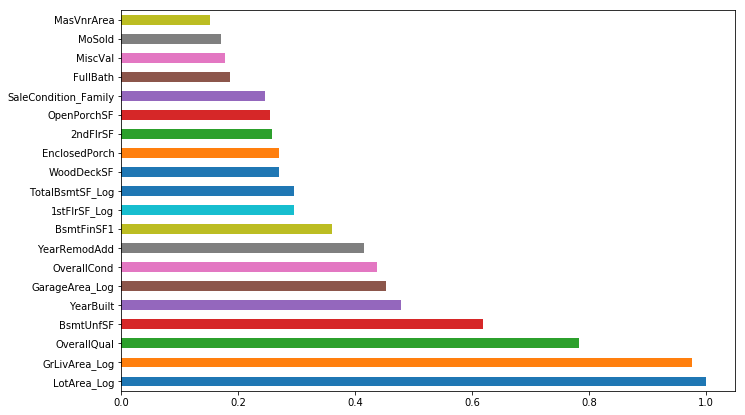

In [26]:
FIGSIZE = (11,7)
type(est.feature_importances_)
fx_imp = pd.Series(est.feature_importances_, index=features)
fx_imp /= fx_imp.max()  # normalize
#fx_imp.sort()
fx_imp.nlargest(20).plot(kind='barh', figsize=FIGSIZE)

## Partial dependence

  * Relationship between the response and a set of features, marginalizing over all other features
  * Intuitively: expected response as a function of the features we conditioned on

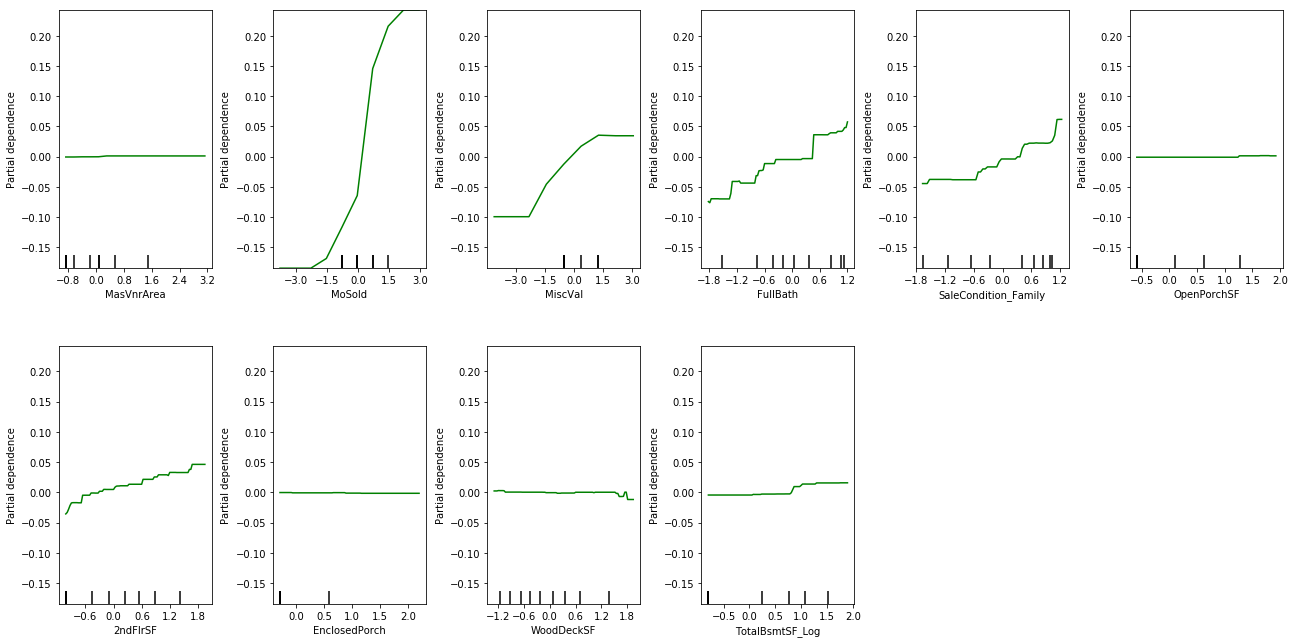

In [33]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
features = ['MasVnrArea', 'MoSold', 'MiscVal', 'FullBath', 'SaleCondition_Family','OpenPorchSF', '2ndFlrSF', 'EnclosedPorch',
           'WoodDeckSF','TotalBsmtSF_Log']
fig, axs = plot_partial_dependence(est, X_train_data, features, feature_names=features, 
                                   n_cols=6, figsize=(20,15))

## Summary & Key Results

In this section, we will present our key findings in terms of key predictor variables and their parameter values. We will also summary the modeling process and learning from it.

## References